# LIBRARY IMPORT

In [25]:
import os
model_inference_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "models",
    "models_root",
    "model_for_inference",
    "ras_pinn"
)
files = sorted(os.listdir(model_inference_dir))
print("Files in directory:")
for f in files:
    print(f" - {f}")
if len(files) == 0:
    raise FileNotFoundError(f"No files found in {model_inference_dir}")
model_file = files[0]  # first file in directory
print(f"Using model file: {model_file}")
landscape_save_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "notebooks",
    "loss_landscape")

Files in directory:
 - median_rank31_RAS_multirun_pinn_206.pth
 - rank1_top3_RAS_multirun_pinn_260.pth
 - rank2_top3_RAS_multirun_pinn_1201.pth
 - rank3_top3_RAS_multirun_pinn_212.pth
Using model file: median_rank31_RAS_multirun_pinn_206.pth


In [26]:
# IMPORTING LIBRARIES
import copy
import csv
import os
import random
import time
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # or ':16:8'

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdDistGeom as molDG
from rdkit.Chem import Descriptors
from rdkit.Chem.rdchem import GetPeriodicTable

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch_geometric.nn import MessagePassing, GCNConv, global_mean_pool, GATConv
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn.inits import reset

import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# FUNCTIONS
from data_processing import load_dataset, smiles_to_graph, process_dataset, generate_graphs
from data_processing_improved import load_dataset_3d, smiles_to_graph_3d, process_dataset_3d
from path_helpers import get_path
from stats_compute import compute_statistics, scale_graphs
from mol_visualize import recon_3d, viz_3d
from smart_loader import load_model_for_inference
import ModelArchitecture
from EnhancedDataSplit import DataSplitter
from collections import defaultdict
from typing import Tuple, List

# DIRECTORY SETUP
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

In [27]:
# HYPERPARAMETER SETTINGS
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Reproducibility settings
seed = 21
split_seed = 42
# Hyperparameters
batch_size = 32
runtime = timestamp

###########################
selected_device = 'cuda' # either 'cuda' or 'cpu
device = torch.device(selected_device)
runtyp = 'model_for_inference'
path = os.path.join(model_inference_dir, model_file)
model = load_model_for_inference(path, device = device)
###########################

# CUDA Deterministic (ON/OFF SETTING)
# For PyTorch
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True


print('device           :', device)
print('seed             :', seed)
print('split seed       :', split_seed)

Architecture inferred from state dict
Model loaded successfully with config: {'node_dim': 20, 'hidden_dim': 64, 'edge_dim': 4, 'graph_layers': 3, 'fc_layers': 3, 'output_dim': 1, 'use_adaptive_pooling': True, 'additional_features_dim': 3}
device           : cuda
seed             : 21
split seed       : 42


# PARITY PLOT

In [28]:
# LOAD & GRAPH GENERATION
df_components = load_dataset(get_path(file_name = 'components_set.csv', folder_name='datasets'))
smiles_dict = dict(zip(df_components['Abbreviation'], df_components['SMILES']))
df_systems = load_dataset(get_path(file_name = 'systems_set.csv', folder_name='datasets'))
smiles_list = df_components["SMILES"].dropna().tolist()
mol_name_dict = smiles_dict.copy()
# GRAPH
system_graphs = process_dataset(df_systems, smiles_dict)
# LOAD DATASET
splitter = DataSplitter(system_graphs, random_state=split_seed)
splitter.print_dataset_stats()
# Options: unseen_amine_split (completely new amines in test set) or stratified_random_split (train val test uncontaminated)
train_data, val_data, test_data = splitter.rarity_aware_unseen_amine_split()
#Retrieve the statistics of train_data
stats = compute_statistics(train_data)
conc_mean = stats[0]
conc_std = stats[1]
temp_mean = stats[2]
temp_std = stats[3]
pco2_mean = stats[4]
pco2_std = stats[5]
#Apply the scaling to validation and test
original_train_data = copy.deepcopy(train_data)
original_val_data = copy.deepcopy(val_data)
original_test_data = copy.deepcopy(test_data)
combined_original_data = original_train_data + original_val_data + original_test_data
train_data = scale_graphs(train_data, conc_mean, conc_std, temp_mean, temp_std, pco2_mean, pco2_std)
val_data = scale_graphs(val_data, conc_mean, conc_std, temp_mean, temp_std, pco2_mean, pco2_std)
test_data = scale_graphs(test_data, conc_mean, conc_std, temp_mean, temp_std, pco2_mean, pco2_std)
#Load the data into DataLoader
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Dataset: 3282 samples, 62 unique amines
Amine type distribution:
  2-primary: 3 amines
  2-primary-2-secondary: 1 amines
  2-primary-3-secondary: 1 amines
  2-primary-secondary: 1 amines
  2-secondary: 2 amines
  2-tertiary: 2 amines
  primary: 15 amines
  primary-secondary: 3 amines
  primary-secondary-tertiary: 1 amines
  secondary: 12 amines
  secondary-tertiary: 3 amines
  tertiary: 18 amines


Processing Very Rare types:
  primary-secondary-tertiary: 1 train, 0 val, 0 test
  2-primary-secondary: 1 train, 0 val, 0 test
  2-primary-3-secondary: 1 train, 0 val, 0 test
  2-primary-2-secondary: 1 train, 0 val, 0 test

Processing Rare types:
  2-secondary: 1 train, 1 val, 0 test
  primary-secondary: 2 train, 1 val, 0 test
  2-tertiary: 1 train, 1 val, 0 test

Processing Medium types:
  secondary-tertiary: 1 train, 1 val, 1 test
  2-primary: 1 train, 1 val, 1 test

Processing Common types:
  primary: 11 train, 2 val, 2 test
  tertiary: 14 train, 2 val, 2 test
  secondary: 10 train, 1 val

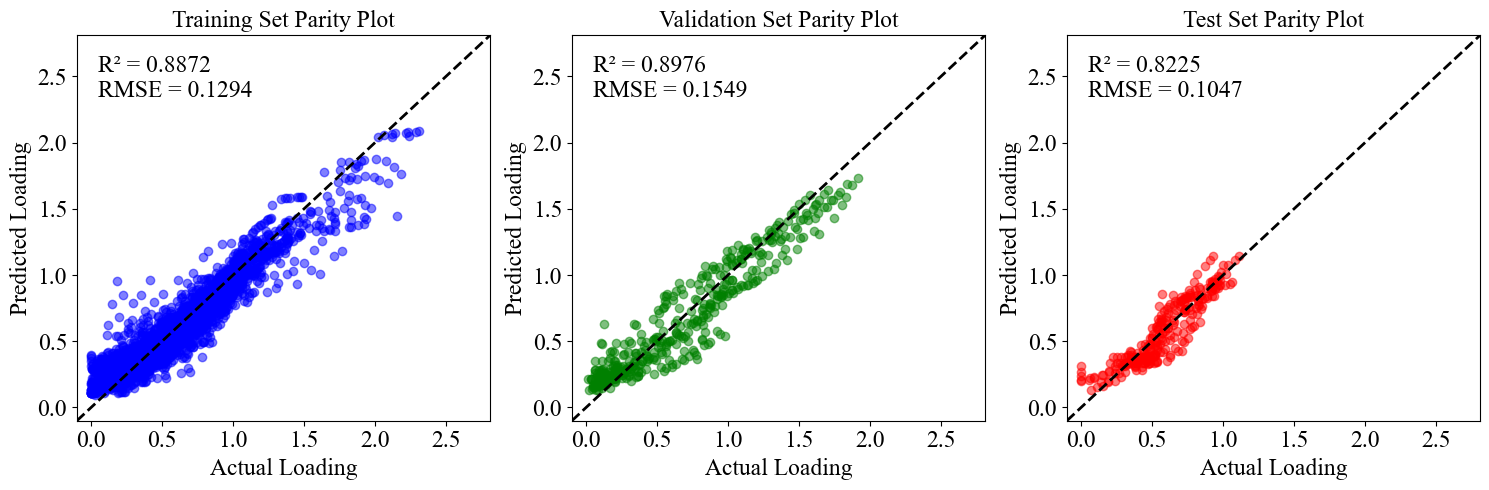

In [29]:
# PARITY PLOT GENERATION
def collect_predictions_and_true_values(model, data_loader, device):
    predictions = []
    true_values = []
    
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy())
            true_values.extend(data.aco2.cpu().numpy())
    
    return predictions, true_values

# Function to calculate R² and RMSE
def calculate_metrics(true_values, predictions):
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    return r2, rmse

# Function to save metrics to CSV
def save_metrics_to_csv(r2_train, rmse_train, r2_val, rmse_val, r2_test, rmse_test, parent_directory):
    # Create the metrics dictionary
    metrics_data = {
        'Dataset': ['Training', 'Validation', 'Test'],
        'R2': [r2_train, r2_val, r2_test],
        'RMSE': [rmse_train, rmse_val, rmse_test]
    }

# Function to plot the parity plot
def plot_parity_plot(train_true_values, train_predictions, val_true_values, val_predictions, test_true_values, test_predictions):
    fontsize = 17
    matplotlib.rcParams['font.family'] = 'Times New Roman'

    # Calculate metrics
    r2_train, rmse_train = calculate_metrics(train_true_values, train_predictions)
    r2_val, rmse_val = calculate_metrics(val_true_values, val_predictions)
    r2_test, rmse_test = calculate_metrics(test_true_values, test_predictions)

    # Plot parity plot
    plt.figure(figsize=(15, 5))

    # Training data parity plot
    plt.subplot(1, 3, 1)
    plt.scatter(train_true_values, train_predictions, edgecolors='b', alpha=0.5, c = 'b')
    plt.plot([-0.1, max(train_true_values)+0.5], [-0.1, max(train_true_values)+0.5], 'k--', linewidth=2)
    plt.xlabel('Actual Loading', fontsize=fontsize)
    plt.ylabel('Predicted Loading', fontsize=fontsize)
    plt.xlim(-0.1, max(train_true_values)+0.5)
    plt.ylim(-0.1, max(train_true_values)+0.5)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title('Training Set Parity Plot', fontsize=fontsize)
    plt.text(0.05, 0.95, f'R² = {r2_train:.4f}\nRMSE = {rmse_train:.4f}', transform=plt.gca().transAxes, fontsize=fontsize, verticalalignment='top')

    # Validation data parity plot
    plt.subplot(1, 3, 2)
    plt.scatter(val_true_values, val_predictions, edgecolors='g', alpha=0.5, c = 'g')
    plt.plot([-0.1, max(train_true_values)+0.5], [-0.1, max(train_true_values)+0.5], 'k--', linewidth=2)
    plt.xlabel('Actual Loading', fontsize=fontsize)
    plt.ylabel('Predicted Loading', fontsize=fontsize)
    plt.xlim(-0.1, max(train_true_values)+0.5)
    plt.ylim(-0.1, max(train_true_values)+0.5)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title('Validation Set Parity Plot', fontsize=fontsize)
    plt.text(0.05, 0.95, f'R² = {r2_val:.4f}\nRMSE = {rmse_val:.4f}', transform=plt.gca().transAxes, fontsize=fontsize, verticalalignment='top')

    # Test data parity plot
    plt.subplot(1, 3, 3)
    plt.scatter(test_true_values, test_predictions, edgecolors='r', alpha=0.5, c = 'r')
    plt.plot([-0.1, max(train_true_values)+0.5], [-0.1, max(train_true_values)+0.5], 'k--', linewidth=2)
    plt.xlabel('Actual Loading', fontsize=fontsize)
    plt.ylabel('Predicted Loading', fontsize=fontsize)
    plt.xlim(-0.1, max(train_true_values)+0.5)
    plt.ylim(-0.1, max(train_true_values)+0.5)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title('Test Set Parity Plot', fontsize=fontsize)
    plt.text(0.05, 0.95, f'R² = {r2_test:.4f}\nRMSE = {rmse_test:.4f}', transform=plt.gca().transAxes, fontsize=fontsize, verticalalignment='top')

    plt.tight_layout()
    plt.show()
    
    # Save metrics to CSV
    save_metrics_to_csv(r2_train, rmse_train, r2_val, rmse_val, r2_test, rmse_test, parent_directory)

# Collect predictions and true values for training, validation, and test data
train_predictions, train_true_values = collect_predictions_and_true_values(model, train_loader, device)
val_predictions, val_true_values = collect_predictions_and_true_values(model, val_loader, device)
test_predictions, test_true_values = collect_predictions_and_true_values(model, test_loader, device)

# Plot the parity plot
plot_parity_plot(train_true_values, train_predictions, val_true_values, val_predictions, test_true_values, test_predictions)

# LOSS LANDSCAPE

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torch.nn.functional as F
import copy
import plotly.graph_objects as go

def physics_total_loss(model, data, s1=1.0, s2=1.0, s3=1.0,
                       pco2_std=None, pco2_mean=None, 
                       temp_std=None, temp_mean=None, 
                       conc_std=None, conc_mean=None):    
    # Physics penalties
    loss_p = ModelArchitecture.grad_pres(model, data, pco2_std, pco2_mean, s1)
    loss_t = ModelArchitecture.grad_temp(model, data, temp_std, temp_mean, s2)
    loss_c = ModelArchitecture.grad_conc(model, data, conc_std, conc_mean, s3)
    
    return loss_p + loss_t + loss_c

def get_random_direction(model, device):
    direction = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            direction[name] = torch.randn_like(param, device=device)
    return direction

def normalize_direction(direction, model):
    direction_norm = 0
    model_norm = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad and name in direction:
            direction_norm += torch.norm(direction[name]) ** 2
            model_norm += torch.norm(param) ** 2
    
    direction_norm = torch.sqrt(direction_norm)
    model_norm = torch.sqrt(model_norm)
    
    # Normalize direction to have same magnitude as model parameters
    for name in direction:
        direction[name] = direction[name] * (model_norm / direction_norm)
    
    return direction

def apply_perturbation(model, direction1, direction2, alpha, beta):
    perturbed_model = copy.deepcopy(model)
    
    for name, param in perturbed_model.named_parameters():
        if param.requires_grad and name in direction1 and name in direction2:
            param.data = param.data + alpha * direction1[name] + beta * direction2[name]
    
    return perturbed_model

def compute_loss_at_point(model, data_loader, criterion, device, target_attr='aco2', 
                         use_custom_loss=False, custom_loss_kwargs=None):
    model.train()
    total_loss = 0
    total_samples = 0
    
    if use_custom_loss and custom_loss_kwargs is None:
        custom_loss_kwargs = {}
    
    for batch in data_loader:
        batch = batch.to(device)
        
        if use_custom_loss:
            # Enable gradients only for custom physics loss
            with torch.set_grad_enabled(True):
                loss = physics_total_loss(model, batch, **custom_loss_kwargs)
        else:
            # Standard evaluation - no gradients needed
            with torch.no_grad():
                output = model(batch)
                target = getattr(batch, target_attr)
                loss = criterion(output.squeeze(), target.float())
        
        total_loss += loss.item() * batch.num_graphs
        total_samples += batch.num_graphs
    
    return total_loss / total_samples

def compute_hessian_trace(model, data_loader, criterion, device, target_attr='aco2', use_custom_loss=False, custom_loss_kwargs=None):
    """
    Approximates the trace of the Hessian matrix by computing the sum of second-order gradients.
    Uses Hutchinson's method with Rademacher random vectors if needed.
    """
    model.eval()
    trace = 0.0
    total_samples = 0

    for batch in data_loader:
        batch = batch.to(device)

        model.zero_grad()

        if use_custom_loss:
            loss = physics_total_loss(model, batch, **custom_loss_kwargs)
        else:
            output = model(batch)
            target = getattr(batch, target_attr)
            loss = criterion(output.squeeze(), target.float())

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        for g in grads:
            if g is not None and g.requires_grad:
                trace += torch.sum(torch.autograd.grad(g, model.parameters(), grad_outputs=torch.ones_like(g), retain_graph=True)[0] ** 2).item()

        total_samples += batch.num_graphs
        break  # Only compute on 1 batch for speed

    return trace


# SEPARATED CALCULATION FUNCTION
def create_loss_landscape(model, data_loader, criterion, device, 
                         grid_size=21, perturbation_range=1.0, target_attr='aco2',
                         use_custom_loss=False, custom_loss_kwargs=None):
    """
    Compute loss landscape data without visualization.
    Returns all necessary data for plotting.
    """
    
    print("Generating random directions...")
    # Generate two random orthogonal directions
    direction1 = get_random_direction(model, device)
    direction2 = get_random_direction(model, device)
    
    # Normalize directions
    direction1 = normalize_direction(direction1, model)
    direction2 = normalize_direction(direction2, model)
    
    # Make directions orthogonal (Gram-Schmidt process)
    dot_product = 0
    for name in direction1:
        dot_product += torch.sum(direction1[name] * direction2[name])
    
    for name in direction2:
        direction2[name] = direction2[name] - dot_product * direction1[name]
    
    direction2 = normalize_direction(direction2, model)
    
    print(f"Computing loss landscape on {grid_size}x{grid_size} grid...")
    
    # Create coordinate grids
    alphas = np.linspace(-perturbation_range, perturbation_range, grid_size)
    betas = np.linspace(-perturbation_range, perturbation_range, grid_size)
    
    # Initialize loss surface
    loss_surface = np.zeros((grid_size, grid_size))
    
    # Compute loss for each point in the grid
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            if (i * grid_size + j) % 50 == 0:
                print(f"Progress: {(i * grid_size + j) / (grid_size * grid_size) * 100:.1f}%")
            
            # Create perturbed model
            perturbed_model = apply_perturbation(model, direction1, direction2, alpha, beta)
            
            # Compute loss
            loss = compute_loss_at_point(
                perturbed_model, data_loader, criterion, device, target_attr,
                use_custom_loss=use_custom_loss, custom_loss_kwargs=custom_loss_kwargs
            )
            loss_surface[i, j] = loss
    
    # Compute Hessian trace
    hessian_trace = compute_hessian_trace(model, data_loader, criterion, device, target_attr, use_custom_loss, custom_loss_kwargs)
    
    print("Loss landscape computation complete!")
    print(f"Hessian Trace (approximate): {hessian_trace:.4f}")
    
    return {
        'alphas': alphas,
        'betas': betas, 
        'loss_surface': loss_surface,
        'hessian_trace': hessian_trace,
        'grid_size': grid_size,
        'perturbation_range': perturbation_range
    }


# SEPARATED VISUALIZATION FUNCTIONS
def plot_loss_landscape_2d(landscape_data, save_path=None, title_suffix=""):
    """
    Create high-quality 2D contour plot from pre-computed landscape data
    """
    alphas = landscape_data['alphas']
    betas = landscape_data['betas']
    loss_surface = landscape_data['loss_surface']
    
    fig = go.Figure(data=go.Contour(
        z=loss_surface.T,
        x=alphas,
        y=betas,
        colorscale='Turbo',
        contours=dict(start=np.min(loss_surface), end=np.max(loss_surface), 
                      size=(np.max(loss_surface)-np.min(loss_surface))/40),
        colorbar=dict(title="", tickformat=".2f",len=1.035,
                      y=0.5,
                      yanchor='middle',
                      tickfont=dict(size=30)
                      ),
    ))

    fig.add_trace(go.Scatter(
        x=[0],
        y=[0],
        mode='markers+text',
        marker=dict(color='red', size=20, symbol='star'),
        text=[f"Trained Model<br>{loss_surface[loss_surface.shape[0]//2, loss_surface.shape[1]//2]:.3f}"],
        textposition='top center',
        textfont=dict(
            color='white',     # change text color here
            size=16,           # optional: text size
            family='Arial'     # optional: font family
        ),
        showlegend=False
    ))


    fig.update_layout(
        xaxis=dict(tickfont=dict(size=30),
                   title=dict(text='Direction 1 (α)', standoff=10,font=dict(size=30))),
        yaxis=dict(tickfont=dict(size=30),
                   title=dict(text='Direction 2 (β)', standoff=0,font=dict(size=30))),
        margin=dict(l=80, r=50, t=100, b=80),
        font=dict(size=16, family='Serif'),
        width=800,
        height=700
    )

    if save_path:
        fig.write_image(f"{save_path}_2d_plotly.png", width=900, height=900, scale=10, 
               engine="kaleido", format="png")

    fig.show()


def plot_loss_landscape_3d(landscape_data, save_path=None, title_suffix=""):
    alphas = landscape_data['alphas']
    betas = landscape_data['betas']
    loss_surface = landscape_data['loss_surface']
    
    i0 = np.argmin(np.abs(alphas))  # index of closest to 0
    j0 = np.argmin(np.abs(betas))
    original_loss = loss_surface[i0, j0]

    min_loss = np.min(loss_surface)
    max_loss = np.max(loss_surface)

    # Generate tick positions and labels
    alpha_ticks = np.linspace(alphas[0], alphas[-1], 5)
    alpha_ticklabels = [f"{val:.2f}" for val in alpha_ticks]
    
    beta_ticks = np.linspace(betas[0], betas[-1], 5)
    beta_ticklabels = [f"{val:.2f}" for val in beta_ticks]

    num_z_ticks = 5
    z_ticks = np.linspace(min_loss, max_loss, num_z_ticks)
    z_ticklabels = [f"{val:.2f}" for val in z_ticks]

    fig = go.Figure(data=[
        go.Surface(
            z=loss_surface.T,
            x=alphas,
            y=betas,
            colorscale='Turbo',
            lighting=dict(
                ambient=0.6,   # soft overall light
                diffuse=0.1,   # gentle shading
                specular=0.2,  # very subtle highlights
                roughness=0.6  # matte, not glossy
            ),
            lightposition=dict(x=30, y=50, z=100),
            colorbar=dict(
                title='Loss',
                title_font=dict(size=14, family='Serif'),
                tickfont=dict(size=14, family='Serif'),
                thickness=20,
                len=0.45,
                outlinecolor='black',
                outlinewidth=1,
                x=0.95,
                y=0.52,
                tickmode='array',
                tickvals=z_ticks,
                ticktext=z_ticklabels
            ),
            showscale=False,
            hoverinfo='x+y+z',
        ),
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[original_loss],
            mode='markers',
            marker=dict(color='red', size=7, symbol='circle'),
            name='Original Model',
            hovertemplate='Original Loss: %{z:.3f}<extra></extra>'
        )
    ])
    
    import math

    angle_deg = -30
    angle_rad = math.radians(angle_deg)

    # Original eye coordinates
    x0, y0, z0 = 1.5, 1.3, 1.0
    zoom_factor = 1.00
    # Rotate clockwise around z-axis
    x_new = x0 * math.cos(angle_rad) + y0 * math.sin(angle_rad)
    y_new = -x0 * math.sin(angle_rad) + y0 * math.cos(angle_rad)
    z_new = z0  # keep height the same
    
    fig.update_layout(
        scene_aspectmode='manual',
        scene_aspectratio=dict(x=1, y=1, z=1),
        font=dict(size=14, family='Serif', color='black'),
        width=800,
        height=700,
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        scene=dict(
            camera=dict(
                eye=dict(x=x_new*zoom_factor, y=y_new*zoom_factor, z=z_new*zoom_factor)
            ),
            xaxis=dict(
                title='Direction 1 (α)',
                title_font=dict(size=16, family='Serif'),
                tickfont=dict(size=14, family='Serif'),
                showgrid=False,
                gridcolor='black',
                zeroline=False,
                zerolinecolor='black',
                zerolinewidth=2,
                tickmode='array',
                tickvals=alpha_ticks,
                ticktext=alpha_ticklabels,
                range=[alphas[0], alphas[-1]],
                backgroundcolor='white',
                showbackground=True,
                linewidth=2,
                linecolor='black',
                mirror=False,
                tickangle=-20,
                visible=False
            ),
            yaxis=dict(
                title='Direction 2 (β)',
                title_font=dict(size=16, family='Serif'),
                tickfont=dict(size=14, family='Serif'),
                showgrid=False,
                gridcolor='black',
                zeroline=False,
                zerolinecolor='black',
                zerolinewidth=2,
                tickmode='array',
                tickvals=beta_ticks,
                ticktext=beta_ticklabels,
                range=[betas[0], betas[-1]],
                backgroundcolor='white',
                showbackground=True,
                linewidth=2,
                linecolor='black',
                mirror=False,
                visible=False
            ),
            zaxis=dict(
                title='Loss',
                title_font=dict(size=16, family='Serif'),
                tickfont=dict(size=14, family='Serif'),
                showgrid=False,
                gridcolor='black',
                zeroline=False,
                zerolinecolor='black',
                tickmode='array',
                tickvals=z_ticks,
                ticktext=z_ticklabels,
                backgroundcolor='white',
                showbackground=True,
                linewidth=2,
                linecolor='black',
                mirror=False,
                tickangle=-7,
                visible=False
            ),
            bgcolor="white"
        ),
        legend=dict(
            font=dict(size=14, family='Serif'),
            bordercolor='black',
            borderwidth=1,
            yanchor='top',
            y=0.95,
            xanchor='right',
            x=0.95,
        )
    )

    if save_path:
        fig.write_image(f"{save_path}_3d_plotly.png", width=900, height=900, scale=5, 
               engine="kaleido", format="png")

    fig.show()

def plot_both_landscapes(landscape_data, save_path=None, title_suffix=""):
    """
    Plot both 2D and 3D visualizations from the same data
    """
    plot_loss_landscape_2d(landscape_data, save_path, title_suffix)
    plot_loss_landscape_3d(landscape_data, save_path, title_suffix)


# CONVENIENCE FUNCTION (backwards compatibility)
def visualize_loss_landscape(model, data_loader, criterion, device, 
                           grid_size=21, perturbation_range=1.0, save_path=None, 
                           target_attr='aco2', use_custom_loss=False, custom_loss_kwargs=None):
    """
    Combined function for backwards compatibility - computes and visualizes
    """
    print("Starting loss landscape visualization...")
    print(f"Grid size: {grid_size}x{grid_size}")
    print(f"Perturbation range: ±{perturbation_range}")
    print(f"Device: {device}")
    
    # Compute landscape
    landscape_data = create_loss_landscape(
        model, data_loader, criterion, device, grid_size, perturbation_range, target_attr,
        use_custom_loss=use_custom_loss, custom_loss_kwargs=custom_loss_kwargs
    )
    
    # Visualize
    print("Creating visualizations...")
    plot_both_landscapes(landscape_data, save_path)
    
    print("Loss landscape visualization complete!")
    
    return landscape_data


# 1D landscape functions (also separated)
def compute_1d_loss_landscape(model, data_loader, criterion, device, 
                            num_points=50, perturbation_range=2.0, target_attr='aco2',
                            use_custom_loss=False, custom_loss_kwargs=None):
    """
    Compute 1D loss landscape data without visualization
    """
    print("Computing 1D loss landscape...")
    
    # Generate random direction
    direction = get_random_direction(model, device)
    direction = normalize_direction(direction, model)
    
    # Create perturbation range
    alphas = np.linspace(-perturbation_range, perturbation_range, num_points)
    losses = []
    
    for alpha in alphas:
        perturbed_model = apply_perturbation(model, direction, {}, alpha, 0)
        loss = compute_loss_at_point(
            perturbed_model, data_loader, criterion, device, target_attr,
            use_custom_loss=use_custom_loss, custom_loss_kwargs=custom_loss_kwargs
        )
        losses.append(loss)
    
    return {
        'alphas': alphas,
        'losses': losses,
        'num_points': num_points,
        'perturbation_range': perturbation_range
    }


def plot_1d_loss_landscape(landscape_1d_data, save_path=None, title_suffix=""):
    """
    Plot 1D loss landscape from pre-computed data
    """
    import matplotlib.pyplot as plt
    
    alphas = landscape_1d_data['alphas']
    losses = landscape_1d_data['losses']
    
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, losses, 'b-', linewidth=2)
    plt.axvline(x=0, color='r', linestyle='--', label='Original Model')
    plt.xlabel('Perturbation (α)')
    plt.ylabel('Loss')
    plt.title(f'1D Loss Landscape{title_suffix}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    if save_path:
        plt.savefig(f"{save_path}_1d.png", dpi=300, bbox_inches='tight')
    
    plt.show()


# USAGE EXAMPLES AND INSTRUCTIONS
print("Loss landscape visualization functions loaded!")
print("\n" + "="*60)
print("SEPARATED CALCULATION & VISUALIZATION WORKFLOW:")
print("="*60)
print("\n1. COMPUTE LANDSCAPE DATA (once):")
print("   landscape_data = create_loss_landscape(model, data_loader, nn.MSELoss(), device, grid_size=15)")
print("\n2. VISUALIZE MULTIPLE TIMES (fast):")
print("   plot_loss_landscape_2d(landscape_data)  # 2D contour")
print("   plot_loss_landscape_3d(landscape_data)  # 3D surface") 
print("   plot_both_landscapes(landscape_data)    # Both plots")
print("\n3. SAVE/LOAD LANDSCAPE DATA:")
print("   # Save: np.savez('landscape.npz', **landscape_data)")
print("   # Load: landscape_data = dict(np.load('landscape.npz'))")
print("\n4. FOR 1D LANDSCAPES:")
print("   data_1d = compute_1d_loss_landscape(model, data_loader, nn.MSELoss(), device)")
print("   plot_1d_loss_landscape(data_1d)")
print("\n" + "="*60)

Loss landscape visualization functions loaded!

SEPARATED CALCULATION & VISUALIZATION WORKFLOW:

1. COMPUTE LANDSCAPE DATA (once):
   landscape_data = create_loss_landscape(model, data_loader, nn.MSELoss(), device, grid_size=15)

2. VISUALIZE MULTIPLE TIMES (fast):
   plot_loss_landscape_2d(landscape_data)  # 2D contour
   plot_loss_landscape_3d(landscape_data)  # 3D surface
   plot_both_landscapes(landscape_data)    # Both plots

3. SAVE/LOAD LANDSCAPE DATA:
   # Save: np.savez('landscape.npz', **landscape_data)
   # Load: landscape_data = dict(np.load('landscape.npz'))

4. FOR 1D LANDSCAPES:
   data_1d = compute_1d_loss_landscape(model, data_loader, nn.MSELoss(), device)
   plot_1d_loss_landscape(data_1d)



In [31]:
""" # ONE-TIME LANDSCAPE GENERATION
custom_loss_kwargs = {
    's1': 10,          # Strength of pCO2 gradient penalty
    's2': 1000,          # Strength of temp gradient penalty
    's3': 10,          # Strength of conc gradient penalty
    'pco2_std': pco2_std, 
    'pco2_mean': pco2_mean,
    'temp_std': temp_std,
    'temp_mean': temp_mean,
    'conc_std': conc_std,
    'conc_mean': conc_mean
}

# Generate surface data 
landscape_data = create_loss_landscape(model, train_loader, nn.MSELoss(), device, 
                                       grid_size=251, 
                                       perturbation_range=1,
                                       use_custom_loss=True, custom_loss_kwargs=custom_loss_kwargs)
def save_landscape_npz(landscape_data, filepath):
    np.savez_compressed(filepath, **landscape_data)
# Save the landscape data
save_landscape_npz(landscape_data=landscape_data, filepath=f'{landscape_save_dir}/pinn_best_True_phys.npz') """

" # ONE-TIME LANDSCAPE GENERATION\ncustom_loss_kwargs = {\n    's1': 10,          # Strength of pCO2 gradient penalty\n    's2': 1000,          # Strength of temp gradient penalty\n    's3': 10,          # Strength of conc gradient penalty\n    'pco2_std': pco2_std, \n    'pco2_mean': pco2_mean,\n    'temp_std': temp_std,\n    'temp_mean': temp_mean,\n    'conc_std': conc_std,\n    'conc_mean': conc_mean\n}\n\n# Generate surface data \nlandscape_data = create_loss_landscape(model, train_loader, nn.MSELoss(), device, \n                                       grid_size=251, \n                                       perturbation_range=1,\n                                       use_custom_loss=True, custom_loss_kwargs=custom_loss_kwargs)\ndef save_landscape_npz(landscape_data, filepath):\n    np.savez_compressed(filepath, **landscape_data)\n# Save the landscape data\nsave_landscape_npz(landscape_data=landscape_data, filepath=f'{landscape_save_dir}/pinn_best_True_phys.npz') "

In [32]:
def load_landscape_npz(filepath):
    loaded = np.load(filepath)
    landscape_data = dict(loaded)
    loaded.close()
    return landscape_data
landscape_data = load_landscape_npz(f'{landscape_save_dir}/pinn_best_True_phys.npz')
image_save_path = os.path.join(
    os.path.dirname(os.getcwd()),
    "notebooks",
    "loss_landscape",
    "physONLY_PIGNN"
)

plot_both_landscapes(landscape_data, image_save_path)


C:\Users\sittb\AppData\Local\Temp\ipykernel_8088\20388868.py:233: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




C:\Users\sittb\AppData\Local\Temp\ipykernel_8088\20388868.py:401: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


